In [1]:
!pip install tensorflow
!pip install keras
!pip install scikeras
!pip install xgboost
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 MB 20.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 53.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 52.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 9.4 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 53.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.1
    Uninstalling numpy-2.1.1:
      Successfully uninstalled numpy-2.1.1

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade p

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import xgboost as xgb

2024-12-10 03:05:05.793249: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 03:05:06.033377: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 03:05:06.158154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733799906.454300   10860 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733799906.546225   10860 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 03:05:07.195831: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [3]:
data = pd.read_csv('./cleaned_data_2.csv')

In [4]:
X = data.drop('readmitted', axis=1)
y = data['readmitted']

#TRUE/FALSE becomes 1/0
X = X.replace({'TRUE': 1, 'FALSE': 0})

In [5]:
# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Apply Label Encoding to categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

In [6]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# SMOTE to handle imbalanced samples
X_train_resampled, X_test, y_train_resampled, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

In [7]:
# Design the autoencoder
input_dimension = X_train_resampled.shape[1]
encoding_dimension = input_dimension // 2  

# Autoencoder architecture
input_layer = Input(shape=(input_dimension,))

encoder = Dense(input_dimension, activation='relu')(input_layer)
encoder = BatchNormalization()(encoder)
encoder = Dropout(0.2)(encoder)
encoder = Dense(encoding_dimension, activation='relu')(encoder)

latent_space = Dense(encoding_dimension // 2, activation='relu')(encoder)

decoder = Dense(encoding_dimension, activation='relu')(latent_space)
decoder = BatchNormalization()(decoder)
encoder = Dropout(0.2)(decoder)
decoder = Dense(input_dimension, activation='linear')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# Training autoencoder with early stopping mechanism
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
autoencoder.fit(
    X_train_resampled, X_train_resampled,
    epochs=50,
    batch_size=64,
    shuffle=True,
    callbacks=[early_stop],
    validation_data=(X_test, X_test)
)

# encoded features are extracted
encoder_model = Model(inputs=input_layer, outputs=encoder)
X_train_encoded = encoder_model.predict(X_train_resampled)
X_test_encoded = encoder_model.predict(X_test)

2024-12-10 03:05:12.419012: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2024-12-10 03:05:12.628026: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 39692328 exceeds 10% of free system memory.


Epoch 1/50


2024-12-10 03:05:12.682962: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 39692328 exceeds 10% of free system memory.


1988/1988 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 4505.3979 - val_loss: 4345.7490
Epoch 2/50
1988/1988 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 4309.4058 - val_loss: 4099.4185
Epoch 3/50
1988/1988 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4040.7104 - val_loss: 3767.4863
Epoch 4/50
1988/1988 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3709.4429 - val_loss: 3412.6973
Epoch 5/50
1988/1988 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 3322.5051 - val_loss: 3015.0889
Epoch 6/50
1988/1988 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2927.2937 - val_loss: 2585.1960
Epoch 7/50
1988/1988 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2511.7148 - val_loss: 2204.1960
Epoch 8/50
1988/1988 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2106.2771 - val_loss: 1769.1082
Epoch 9/50
1988/1988 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1707.7123 - val_loss: 1408.2827
Epoch 10/50
1988/1988 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1333.9142 - val_loss: 1053.0377
Epoch 11/50
1988/1988 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 993.838

2024-12-10 03:07:28.695831: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 39692328 exceeds 10% of free system memory.


3976/3976 ━━━━━━━━━━━━━━━━━━━━ 3s 783us/step
994/994 ━━━━━━━━━━━━━━━━━━━━ 1s 831us/step


In [8]:
#Large and Thought Out Grid Search
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [6, 8, 10],
#     'learning_rate': [0.1, 0.2, 0.3, 0.5],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
# }

#Results that we got
param_grid = {
    'n_estimators': [300],
    'max_depth': [10],
    'learning_rate': [0.3],
    'subsample': [0.8],
    'colsample_bytree': [1.0],
}

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss'
)

In [9]:
warnings.filterwarnings("ignore", message=".*Parameters.*")

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_encoded, y_train_resampled)

# Best model
best_xgb = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Parameters from Grid Search:")
print(best_params)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Parameters from Grid Search:
{'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 300, 'subsample': 0.8}


In [10]:
y_pred = best_xgb.predict(X_test_encoded)
y_pred_proba = best_xgb.predict_proba(X_test_encoded)[:, 1]

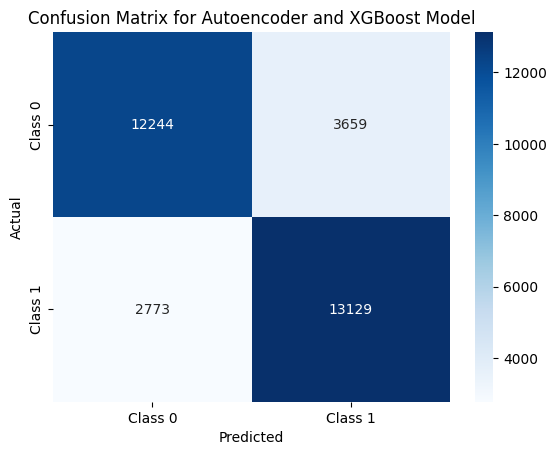

Accuracy: 0.80
Precision: 0.78
Recall: 0.83
F1-Score: 0.80
AUC-ROC: 0.87


In [11]:
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title(f"Confusion Matrix for Autoencoder and XGBoost Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

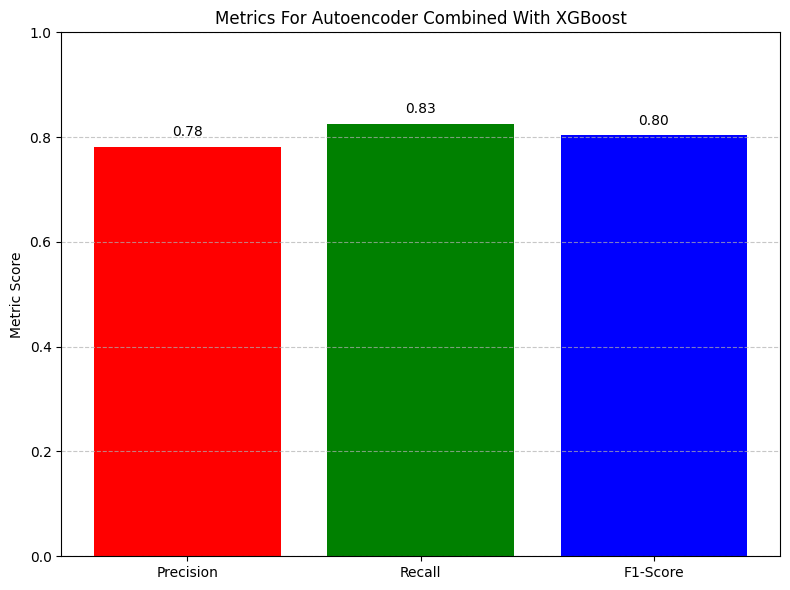

In [12]:
metrics = ['Precision', 'Recall', 'F1-Score']
values = [precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['red', 'green', 'blue'])

plt.ylabel('Metric Score')
plt.title('Metrics For Autoencoder Combined With XGBoost')
plt.ylim(0, 1)  
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, value in enumerate(values):
    plt.text(i, value + 0.02, f"{value:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [13]:
!pip install shap --upgrade
!pip install lime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.9/543.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 49.1 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 50.7 MB/s eta 0:00:00:00:01
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=2f755b5c845dd23742360928524e05674b435cb9a72a367a4f2d53746cb73f5e
  Stored in directory: /home/codespace/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|===================| 31793/31805 [19:23<00:00]        

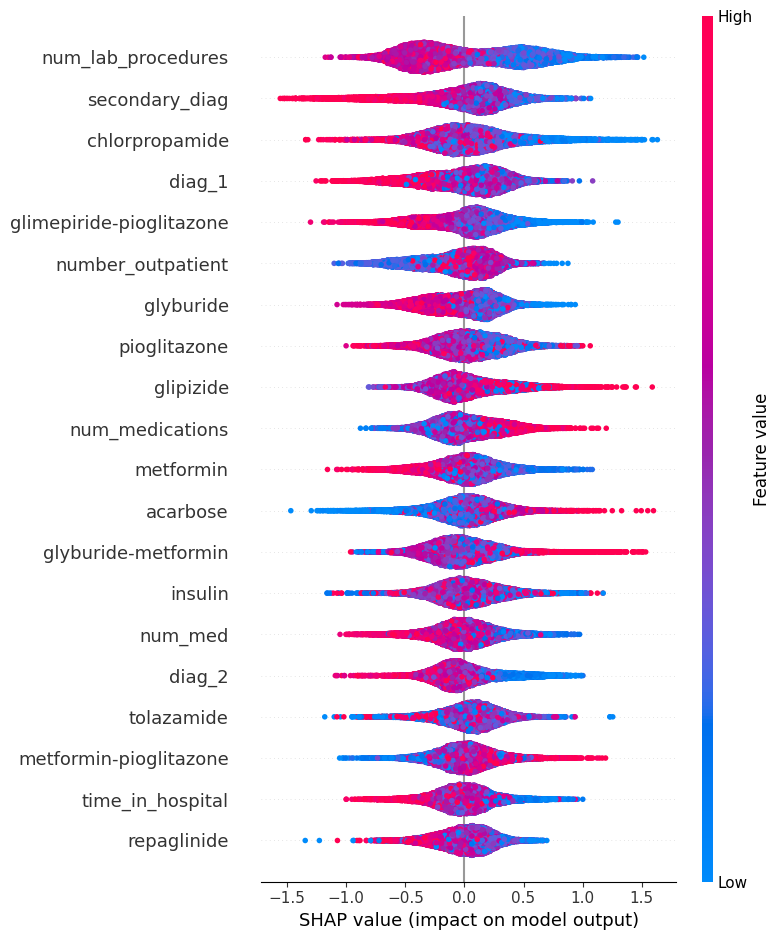

In [14]:
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer

explainer = shap.Explainer(best_xgb, X_train_encoded)
shap_values = explainer(X_test_encoded)
shap.summary_plot(shap_values, X_test_encoded, feature_names=X.columns)

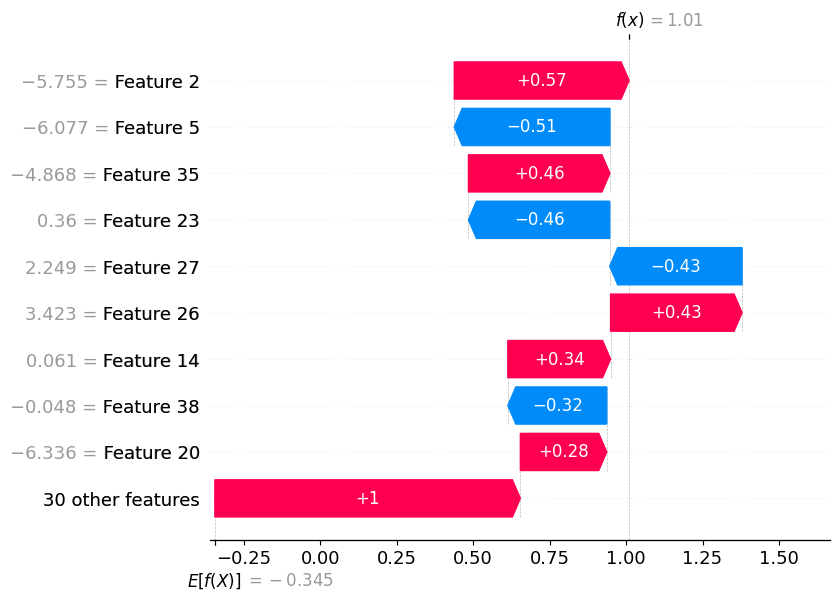

In [15]:
single_index = 0 
shap.waterfall_plot(shap_values[single_index])

lime_explainer = LimeTabularExplainer(
    training_data=X_train_encoded,
    feature_names=X.columns.tolist(), 
    class_names=["Not Readmitted", "Readmitted"],
    mode='classification'
)

instance_to_explain = X_test_encoded[single_index] 

lime_exp = lime_explainer.explain_instance(
    data_row=instance_to_explain,
    predict_fn=best_xgb.predict_proba
)

lime_exp.show_in_notebook()